# This notebook provide an example of classification for this competition

Importation dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import webcolors
import seaborn as sb

import sys
sys.path.append("../..")
import utilities_plot as up
import utilities

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)

train.head(5)

(165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
test.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

# No Missing Data

# Data Visualisation

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

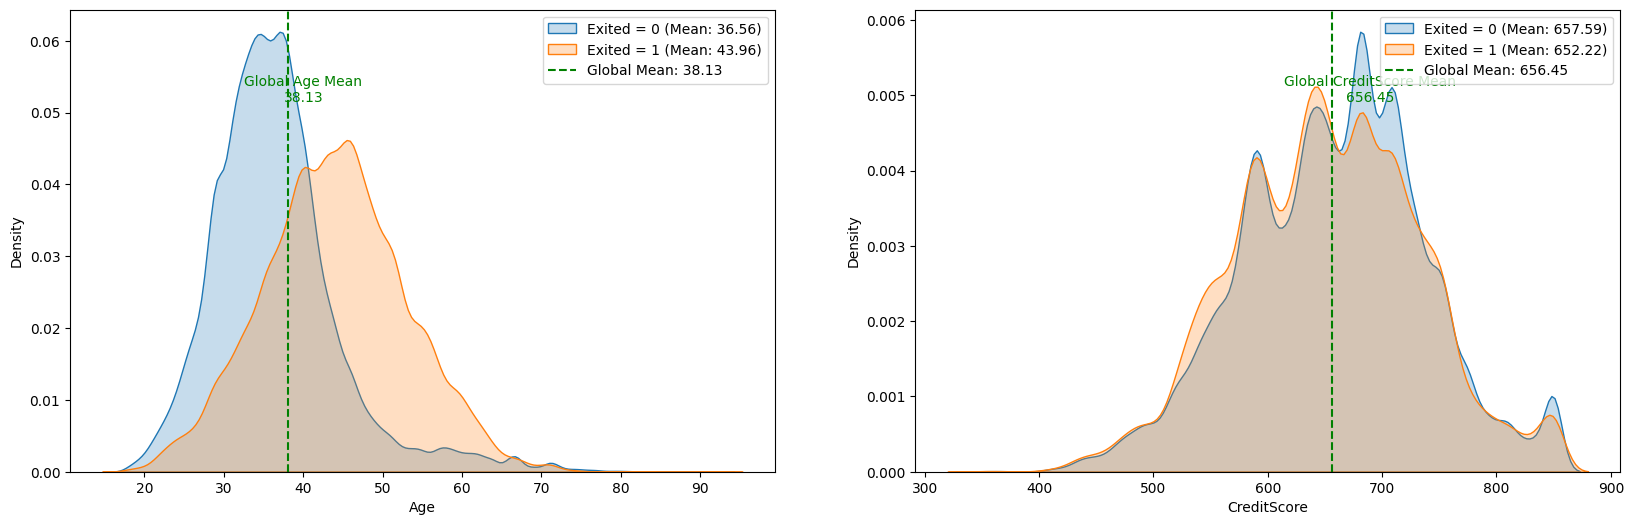

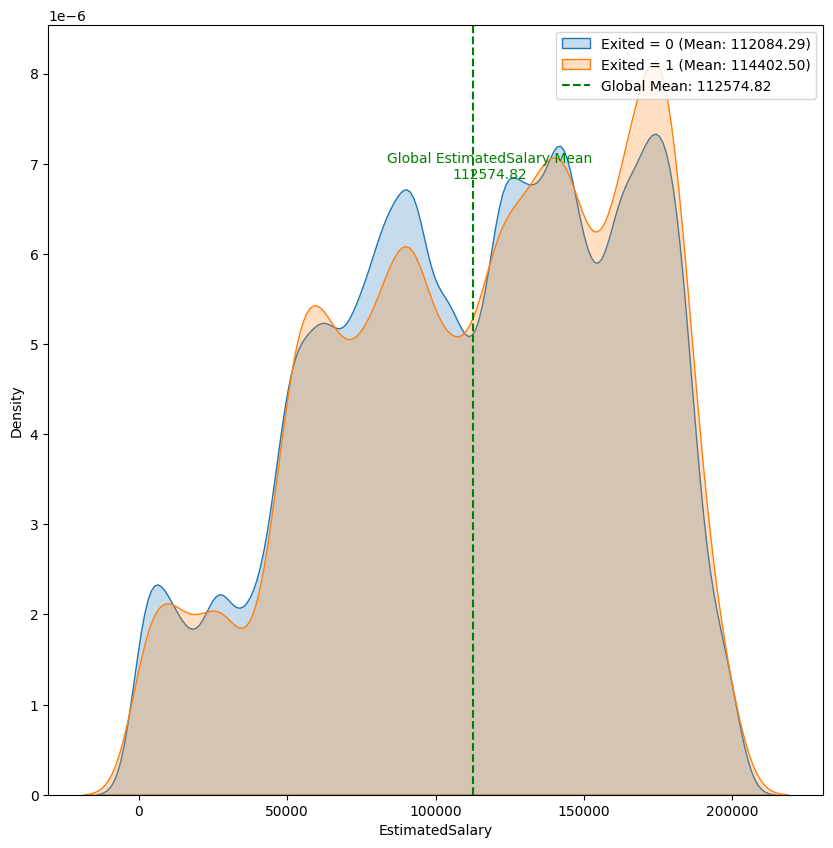

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

up.density_on_target(train, "Exited", "Age", ax= axes[0])

up.density_on_target(train, "Exited", "CreditScore", ax= axes[1])

up.density_on_target(train, "Exited", "EstimatedSalary")



array([<Axes: title={'center': 'Gender = Male\nMean: 0.51'}, xlabel='IsActiveMember', ylabel='Density'>,
       <Axes: title={'center': 'Gender = Female\nMean: 0.48'}, xlabel='IsActiveMember'>],
      dtype=object)

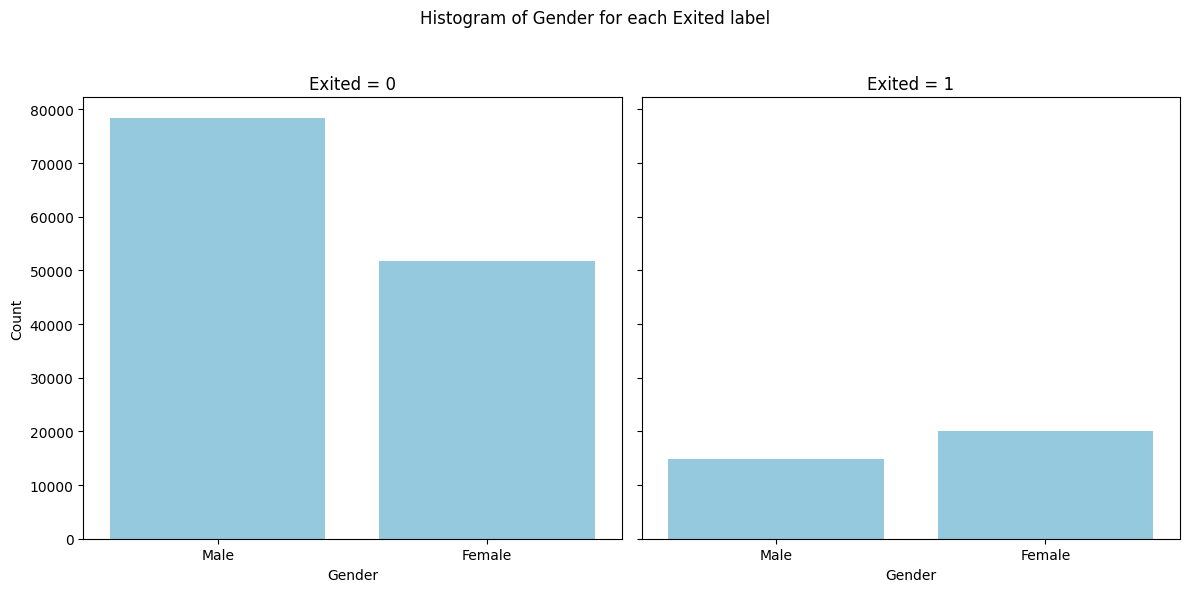

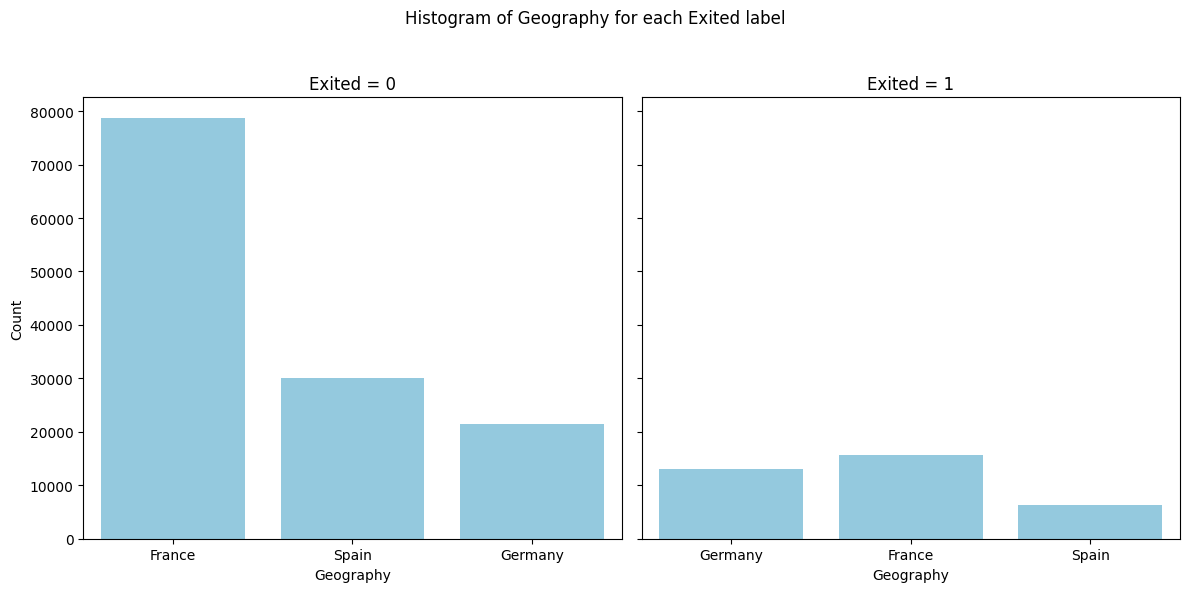

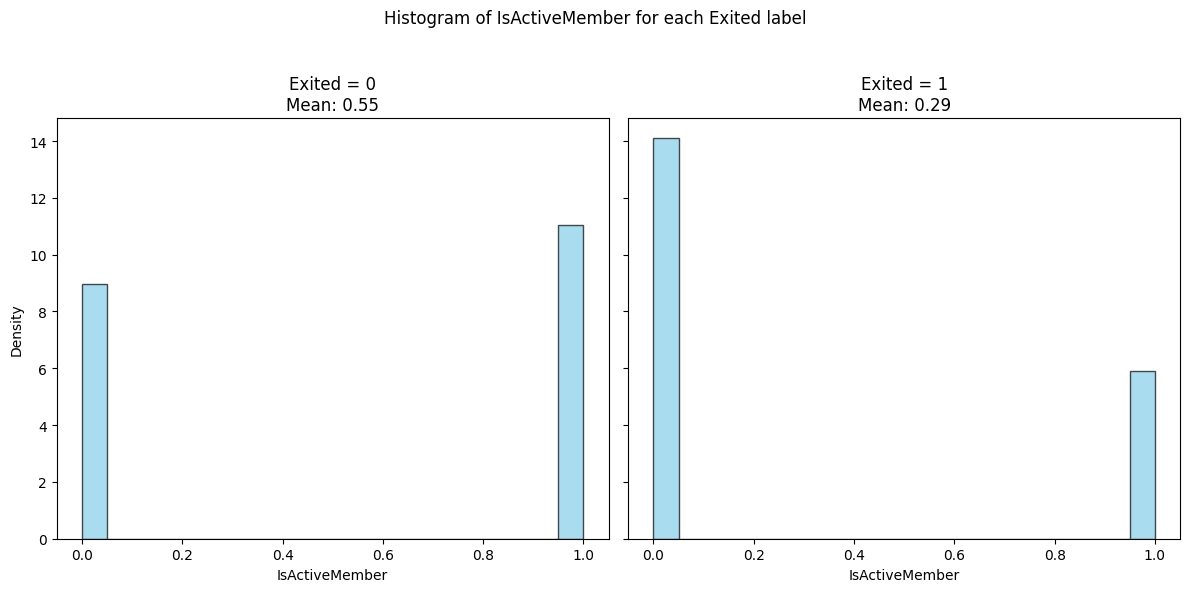

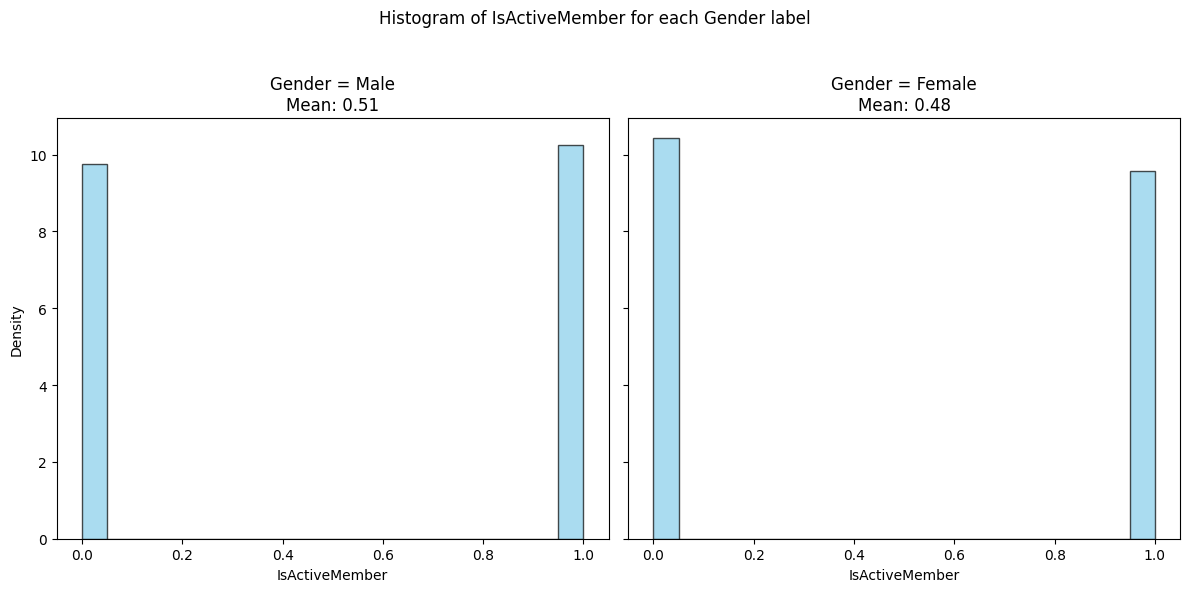

In [7]:
up.histogram_on_target(train, "Exited", "Gender", bins = 20)
up.histogram_on_target(train, "Exited", "Geography", bins = 20)
up.histogram_on_target(train, "Exited", "IsActiveMember", bins = 20)
up.histogram_on_target(train, "Gender", "IsActiveMember", bins = 20)

# Labelize data

[INFO] : labelize processing...
labelize : Geography
labelize : Gender
[INFO] : end labelize processing


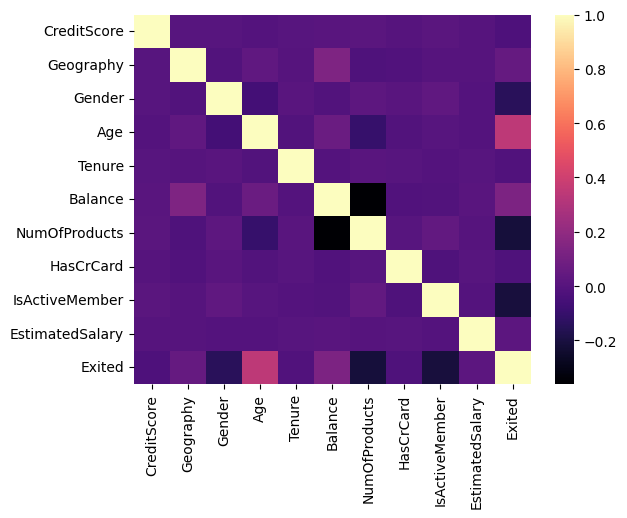

In [27]:
train_transform = train.copy()
test_transform = test.copy()


train_transform = train_transform.drop(["CustomerId", "Surname", "id"], axis=1)
test_transform  = test_transform.drop(["CustomerId", "Surname"], axis=1)

Id_test = test_transform.pop("id")

train_encode, test_encode = utilities.labelize_data(train_transform, test_transform)
train_encode.head(5)

y_train = train_encode.pop("Exited")

# Prepare for training

In [28]:
x_train, x_val, y_train, y_val = train_test_split(train_encode,
                                                  y_train,
                                                  test_size = 0.3, random_state = 42)

print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",y_train.shape)
print("len label_val: ", y_val.shape)

len x_train:  (115523, 10)
len x_val:  (49511, 10)
len label_train:  (115523,)
len label_val:  (49511,)


# Training on usual classfifiaction model

In [31]:
def train_model(model, cross_val: bool, x_train : pd.DataFrame = x_train, y_train : pd.Series = y_train, 
                x_val : pd.DataFrame = x_val, y_val : pd.Series = y_val):
    
    """train model

        Args:
            model (_type_): 
                the model we want
            cross_val (bool): 
                if we want the cross val
                
            x_train (pd.DataFrame, optional): 
                Defaults to x_train.
                
            y_train (pd.Series, optional): 
                Defaults to y_train.
                
            x_val (pd.DataFrame, optional):
                Defaults to x_val.
                
            y_val (pd.Series, optional):
                Defaults to y_val.
                
        Returns:
            the trained model
    """
    
    if cross_val:
        print("[INFO] : cross val score...")
        # Perform cross-validation
        cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV

        # Print each fold's score and the mean score
        print("Cross-validation scores for each fold:", cv_scores)
        print("Mean CV score:", cv_scores.mean())
        print("Standard deviation of CV scores:", cv_scores.std())
        print()

    print("[INFO] : train model...")
    model.fit(x_train, y_train)
    pred_cat = model.predict(x_val)
    print("[INFO] : end training")
    print()

    print("Accuracy : ",  accuracy_score(y_val, pred_cat))
    
    cm = confusion_matrix(y_val, pred_cat)
    sb.heatmap(cm,annot = True,fmt = ".1f")
    plt.show()
    
    return model

[INFO] : cross val score...
Cross-validation scores for each fold: [0.86059295 0.86305994 0.86275698 0.8630973  0.86378982]
Mean CV score: 0.8626593974215029
Standard deviation of CV scores: 0.0010871795724755843

[INFO] : train model...
[INFO] : end training

Accuracy :  0.8646563389953748


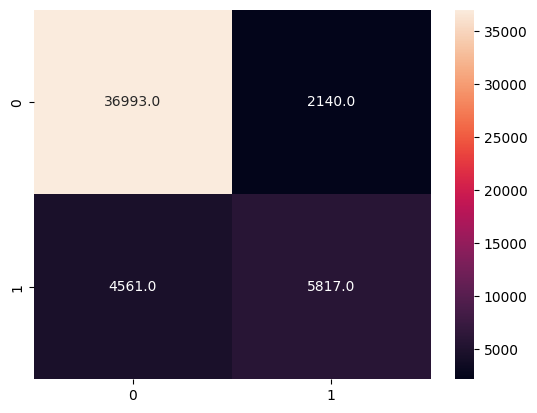

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
XGB = XGBClassifier()

train_model(XGB, True)

# Bagging

#### Bagging, short for **"Bootstrap Aggregating"**, is an ensemble learning technique that improves model stability and accuracy by training multiple versions of a model on different random subsets of the data. Each subset is created using bootstrapping (sampling with replacement), allowing each model to learn from slightly varied data. In the end, predictions from all models are combined, typically by averaging (for regression) or majority vote (for classification), to produce a final output. Bagging reduces variance, making models like decision trees more robust and less prone to overfitting.
https://datascientest.com/machine-learning-le-bagging

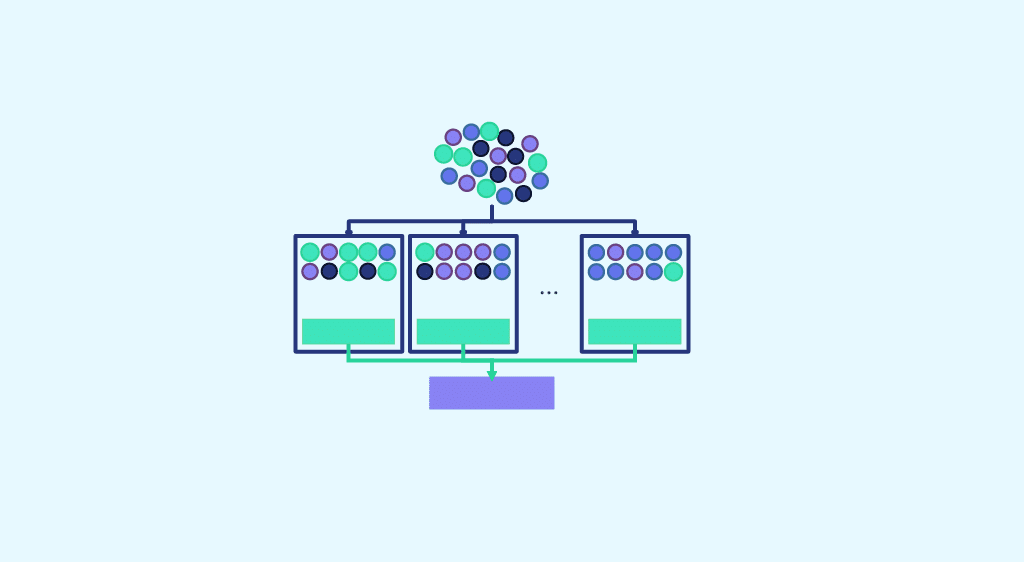

In [35]:
def bag_model(model: XGBClassifier | RandomForestClassifier, cross_val: bool = True,
              x_train: pd.DataFrame = x_train, y_train: pd.Series = y_train, x_val: pd.DataFrame = x_val, y_val: pd.Series = y_val):
    
    """ function to use the baggingclassifier method
    
    Args:
        model (XGBClassifier | RandomForestClassifier ...)
        
        cross_val (bool):
            True by default, if we want or not to do cross validation
            
        x_train (pd.DataFrame) : by default will take the x_train variable defined in the notebook
        y_train (pd.Series) : by default will take the y_train variable defined in the notebook
        x_val (pd.DataFrame) : by default will take the x_val variable defined in the notebook
        y_val (pd.Series) : by default will take the y_val variable defined in the notebook
            

    Returns:
        the trained model
    """
    
    print("[INFO] : BaggingClassifier processing...")
    bag = BaggingClassifier(estimator=model,
                            n_estimators=10, 
                            random_state=0).fit(x_train, y_train)

    predictions_bag = bag.predict(x_val)

    print("accuracy bag: ",  accuracy_score(y_val, predictions_bag))
    print()

    if cross_val:
        print("[INFO] : cross validation")
        scores = cross_val_score(bag, x_train, y_train, cv=5, scoring='accuracy')
        print("Cross-validation accuracy scores: ", scores)
        print("Mean cross-validation accuracy: ", scores.mean())
        
        print("[INFO] : end cross validation")
        print()
        
    print("[INFO] : end bagging process")
    return bag


# ex with xgb
bag = bag_model(XGBClassifier(random_state=42))

[INFO] : BaggingClassifier processing...
accuracy bag:  0.8664741168629193

[INFO] : cross validation
Cross-validation accuracy scores:  [0.86219433 0.8642718  0.86570006 0.86469875 0.86712258]
Mean cross-validation accuracy:  0.8647975054865149
[INFO] : end cross validation

[INFO] : end bagging process


# Voting

#### Voting is an ensemble method that combines predictions from multiple models to improve overall performance and stability. In voting, different algorithms (or versions of the same algorithm) make predictions on the same dataset, and their outputs are aggregated to form a final prediction. For classification, this can be done using majority voting, where the class with the most votes is selected, or by weighted voting if some models are given more importance. For regression, predictions are typically averaged. Voting helps to reduce individual model errors, leading to a more reliable and accurate final prediction.
https://www.kaggle.com/code/saurabhshahane/voting-classifier

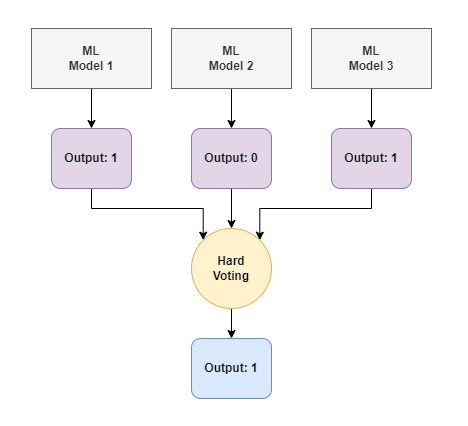

In [38]:
def voting_models(models: list, cross_val: bool = True,
              x_train: pd.DataFrame = x_train, y_train: pd.Series = y_train, x_val: pd.DataFrame = x_val, y_val: pd.Series = y_val):
    
    """ 
        function to use the baggingclassifier method
        
        Args:
            model (list):
            
            cross_val (bool):
                True by default, if we want or not to do cross validation
                
            x_train (pd.DataFrame) : by default will take the x_train variable defined in the notebook
            y_train (pd.Series) : by default will take the y_train variable defined in the notebook
            x_val (pd.DataFrame) : by default will take the x_val variable defined in the notebook
            y_val (pd.Series) : by default will take the y_val variable defined in the notebook
                

        Returns:
            the trained model
    """
    print("[INFO] : voting processing...")
    voting = VotingClassifier(estimators=models, voting='soft')
    voting.fit(x_train, y_train)
    predictions_boost = voting.predict(x_val)

    print("accuracy boost: ",  accuracy_score(y_val, predictions_boost))
    print("[INFO] : end voting")

    if cross_val:
        print("[INFO] : cross validation...")
        scores = cross_val_score(voting, x_train, y_train, cv=5, scoring='accuracy')
        print("Cross-validation accuracy scores: ", scores)
        print("Mean cross-validation accuracy: ", scores.mean())
        print("[INFO] : end cross validation")
        
    
    return voting


vot = voting_models([('xgb', XGBClassifier()), ('cat', CatBoostClassifier()), ('lgb', lgb.LGBMClassifier(verbosity=-1))])

[INFO] : voting processing...
Learning rate set to 0.078288
0:	learn: 0.6222622	total: 75.6ms	remaining: 1m 15s
1:	learn: 0.5656572	total: 89ms	remaining: 44.4s
2:	learn: 0.5232533	total: 101ms	remaining: 33.5s
3:	learn: 0.4883639	total: 112ms	remaining: 27.8s
4:	learn: 0.4609098	total: 124ms	remaining: 24.7s
5:	learn: 0.4396682	total: 138ms	remaining: 22.9s
6:	learn: 0.4201031	total: 156ms	remaining: 22.1s
7:	learn: 0.4057774	total: 168ms	remaining: 20.9s
8:	learn: 0.3940768	total: 180ms	remaining: 19.8s
9:	learn: 0.3845896	total: 193ms	remaining: 19.1s
10:	learn: 0.3761684	total: 208ms	remaining: 18.7s
11:	learn: 0.3686765	total: 221ms	remaining: 18.2s
12:	learn: 0.3627838	total: 236ms	remaining: 17.9s
13:	learn: 0.3578075	total: 257ms	remaining: 18.1s
14:	learn: 0.3537072	total: 271ms	remaining: 17.8s
15:	learn: 0.3500298	total: 282ms	remaining: 17.4s
16:	learn: 0.3468422	total: 294ms	remaining: 17s
17:	learn: 0.3446501	total: 306ms	remaining: 16.7s
18:	learn: 0.3423867	total: 318ms

# Submission

In [48]:
def submission(model, test, Id):
    pred = model.predict_proba(test)
    print(pred)
    pred_label = [1 if i>=0.5 else 0 for i in pred[:, 1]]

    submission = pd.DataFrame({'id': Id,
                               'Response': pred_label})
    
    # Save submission to a CSV file
    #submission.to_csv('submission.csv', index=False)
    
submission(vot, test_encode, Id_test)

[[0.97296111 0.02703888]
 [0.17438577 0.82561423]
 [0.97288882 0.02711119]
 ...
 [0.97744198 0.02255801]
 [0.86772119 0.13227881]
 [0.83666642 0.16333359]]
            id  Response
0       165034         0
1       165035         1
2       165036         0
3       165037         0
4       165038         0
...        ...       ...
110018  275052         0
110019  275053         0
110020  275054         0
110021  275055         0
110022  275056         0

[110023 rows x 2 columns]
